<a href="https://colab.research.google.com/github/swastipriya/Deep-Learning/blob/master/Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [94]:
import pandas as pd
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras import Sequential
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

## Loading the dataset

In [17]:
#load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify = np.array(y_train), random_state=42)
#one hot encoding target variables
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape) 

170500096/170498071 [==============================] - 2s 0us/step
x_train:  (42500, 32, 32, 3) y_train:  (42500, 10)
x_val:  (7500, 32, 32, 3) y_val:  (7500, 10)
x_test:  (10000, 32, 32, 3) y_test:  (10000, 10)


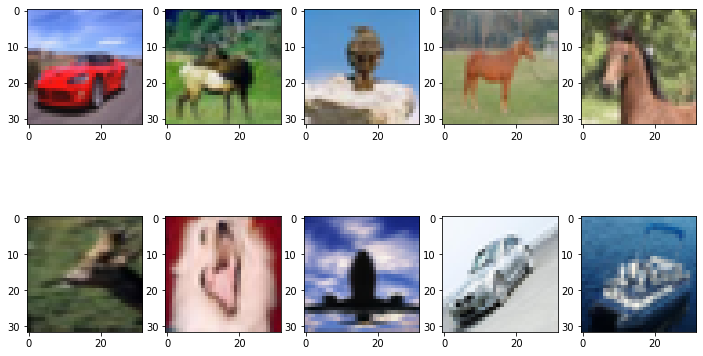

In [ ]:
# plot first few images
fig = plt.figure(figsize=(12,7))
for i in range(10):
  # define subplot
	plt.subplot(2, 5, i+1)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

## Preprocessing data

VGG16 takes input images having minimum of 48 pixels of height and width. Therefore resizing the images

In [18]:
x_train = np.array([resize(x, (48, 48)) for x in x_train])
x_val = np.array([resize(x,(48, 48)) for x in x_val])
x_test = np.array([resize(x,(48, 48)) for x in x_test])
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape)

x_train:  (42500, 48, 48, 3) y_train:  (42500, 10)
x_val:  (7500, 48, 48, 3) y_val:  (7500, 10)
x_test:  (10000, 48, 48, 3) y_test:  (10000, 10)


## Preparing Model

In [45]:
batch_size= 32
epochs= 40
nb_classes= 10
learning_rate= 0.0001

In [46]:
base_model = vgg.VGG16(weights= 'imagenet', include_top= False, input_shape=(48,48,3))

In [47]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [48]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [49]:
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(nb_classes, activation='softmax')(x)
model = Model(base_model.input, pred)

In [50]:
for layer in base_model.layers:
     layer.trainable = False

In [51]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= learning_rate), metrics=['accuracy'])

In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

## Data Augmentation

In [53]:
train_data_gen = ImageDataGenerator(rescale = 1./255)
train_data_gen.fit(x_train)
train_generator = train_data_gen.flow(x_train, y_train, batch_size=batch_size)

In [54]:
validation_data_gen = ImageDataGenerator(rescale = 1./255)
validation_data_gen.fit(x_val)
validation_generator = validation_data_gen.flow(x_val, y_val, batch_size=batch_size)

In [66]:
test_batch_size=100
test_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen.fit(x_test)
test_generator = test_data_gen.flow(x_test, y_test, batch_size=test_batch_size)

## Training model

In [55]:

train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=epochs,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 29s 22ms/step - loss: 1.8496 - accuracy: 0.3339 - val_loss: 1.6692 - val_accuracy: 0.4774
Epoch 2/40
1328/1328 [==============================] - 28s 21ms/step - loss: 1.5176 - accuracy: 0.4600 - val_loss: 1.3690 - val_accuracy: 0.5276
Epoch 3/40
1328/1328 [==============================] - 28s 21ms/step - loss: 1.4045 - accuracy: 0.5022 - val_loss: 1.3322 - val_accuracy: 0.5541
Epoch 4/40
1328/1328 [==============================] - 28s 21ms/step - loss: 1.3322 - accuracy: 0.5295 - val_loss: 1.3999 - val_accuracy: 0.5778
Epoch 5/40
1328/1328 [==============================] - 29s 21ms/step - loss: 1.2853 - accuracy: 0.5443 - val_loss: 1.3872 - val_accuracy: 0.5848
Epoch 6/40
1328/1328 [==============================] - 28s 21ms/step - loss: 1.2491 - accuracy: 0.5577 - val_loss: 1.1652 - val_accuracy: 0.5992
Epoch 7/40
1328/1328 [==============================] - 28s 21ms/step - loss: 1.2123 - accuracy: 0.5750 - val_loss: 1.0299 -

In [95]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

save_history(history, 'history_augmented_1.bin') # categorical_crossentropy
model.save('pre_trained_vgg16_1.h5')

In [96]:
# load model
model = load_model('/content/drive/My Drive/00_transfer_learning/pre_trained_vgg16_1.h5')

## Evaluate Model

In [57]:
total_validation = 7500
score = model.evaluate_generator(generator=validation_generator, steps=total_validation // batch_size)
score

[1.1409269571304321, 0.6746794581413269]

## Model Performance

In [23]:
def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

In [37]:
history = load_history('/content/drive/My Drive/00_transfer_learning/history_augmented.bin')

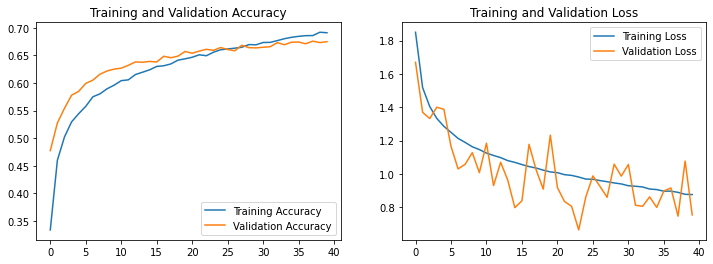

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

In [62]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [92]:
test_generator.reset()
total_test = 10000
prediction=model.predict_generator(test_generator,
                                   steps=total_test // test_batch_size,
                                   verbose=1)

100/100 [==============================] - 4s 42ms/step


In [ ]:
test_class_indices=np.argmax(y_test,axis=1)
labels = label_dict
test_labels = [labels[k] for k in test_class_indices]

In [89]:
predicted_class_indices=np.argmax(prediction,axis=1)
labels = label_dict
predictions = [labels[k] for k in predicted_class_indices]

In [97]:
results=pd.DataFrame({"Test Labels":test_labels,
                      "Predictions":predictions})
results.to_csv("results_with_augmentation.csv",index=False)